# 0) Import Library

In [1]:
# Library
import os
import zipfile
import tensorflow_datasets as tfds
import matplotlib.image as mpimg
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.datasets import fashion_mnist
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import numpy as np
import os
from datetime import datetime
import keras

# Load the TensorBoard notebook extension
%load_ext tensorboard

Using TensorFlow backend.


# 1) Function

In [0]:
# Define Callbacks
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.98):
      print("\nReached 90% accuracy so cancelling training!")
      self.model.stop_training = True

# Tensorboard
logdir = os.path.join("logs", datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

# 2) Prepare Dataset


## 2.1) Download Data

In [3]:
# Download Data
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip \
    -O /tmp/horse-or-human.zip

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip \
    -O /tmp/validation-horse-or-human.zip

--2020-04-19 14:04:21--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.14.80, 2607:f8b0:4007:804::2010
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.14.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘/tmp/horse-or-human.zip’

/tmp/horse-or-human 100%[===================>] 142.65M   141MB/s    in 1.0s    

2020-04-19 14:04:22 (141 MB/s) - ‘/tmp/horse-or-human.zip’ saved [149574867/149574867]

--2020-04-19 14:04:23--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.11.80, 2607:f8b0:4007:80e::2010
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.11.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11480187 (11M) [application/z

In [0]:
local_zip = '/tmp/horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/horse-or-human')
local_zip = '/tmp/validation-horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/validation-horse-or-human')
zip_ref.close()

## 2.2) Data Analysis


In [0]:
# Directory with our training horse pictures
train_horse_dir = os.path.join('/tmp/horse-or-human/horses')

# Directory with our training human pictures
train_human_dir = os.path.join('/tmp/horse-or-human/humans')

# Directory with our training horse pictures
validation_horse_dir = os.path.join('/tmp/validation-horse-or-human/horses')

# Directory with our training human pictures
validation_human_dir = os.path.join('/tmp/validation-horse-or-human/humans')

In [6]:
train_horse_names = os.listdir(train_horse_dir)
print(train_horse_names[:10])

train_human_names = os.listdir(train_human_dir)
print(train_human_names[:10])

validation_horse_hames = os.listdir(validation_horse_dir)
print(validation_horse_hames[:10])

validation_human_names = os.listdir(validation_human_dir)
print(validation_human_names[:10])

['horse48-7.png', 'horse21-1.png', 'horse29-9.png', 'horse43-0.png', 'horse44-7.png', 'horse33-7.png', 'horse50-5.png', 'horse40-6.png', 'horse21-4.png', 'horse03-6.png']
['human12-01.png', 'human15-18.png', 'human02-17.png', 'human16-26.png', 'human01-30.png', 'human09-02.png', 'human04-21.png', 'human04-15.png', 'human13-10.png', 'human16-01.png']
['horse3-217.png', 'horse5-100.png', 'horse1-105.png', 'horse1-276.png', 'horse2-441.png', 'horse4-439.png', 'horse2-269.png', 'horse5-192.png', 'horse3-416.png', 'horse4-159.png']
['valhuman05-05.png', 'valhuman05-27.png', 'valhuman01-04.png', 'valhuman04-14.png', 'valhuman02-20.png', 'valhuman05-26.png', 'valhuman01-23.png', 'valhuman02-11.png', 'valhuman03-07.png', 'valhuman04-23.png']


In [7]:
print('total training horse images:', len(os.listdir(train_horse_dir)))
print('total training human images:', len(os.listdir(train_human_dir)))
print('total validation horse images:', len(os.listdir(validation_horse_dir)))
print('total validation human images:', len(os.listdir(validation_human_dir)))

total training horse images: 500
total training human images: 527
total validation horse images: 128
total validation human images: 128


## 2.3) Data Visualization

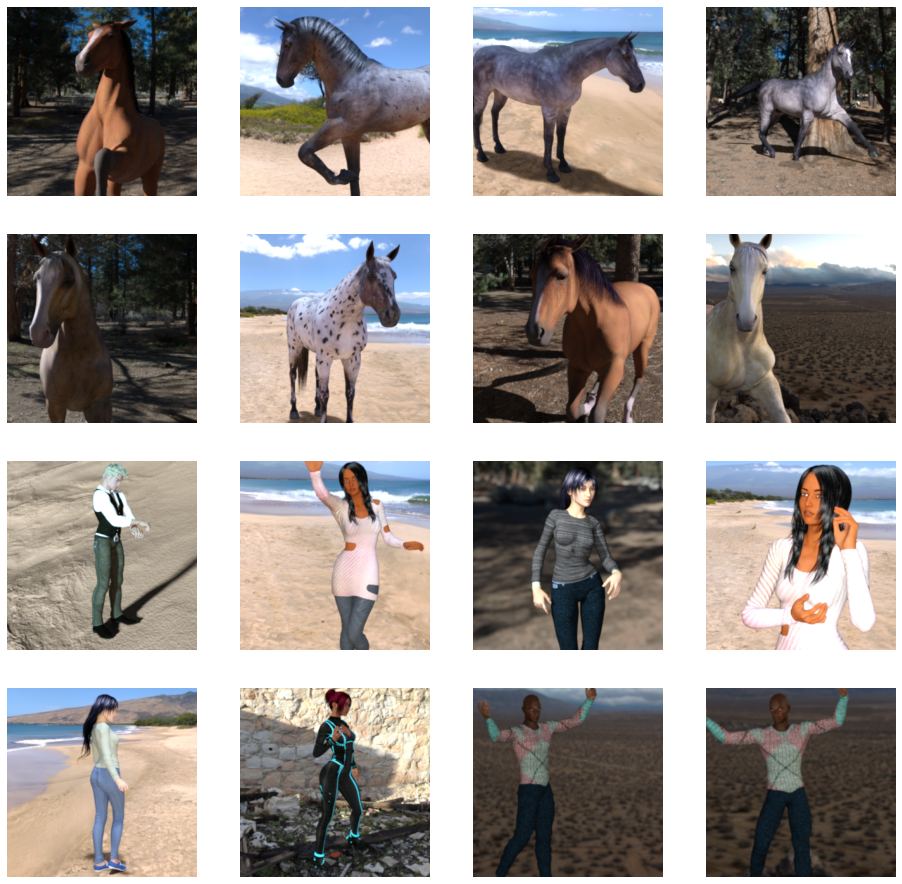

In [8]:
# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_horse_pix = [os.path.join(train_horse_dir, fname) 
                for fname in train_horse_names[pic_index-8:pic_index]]
next_human_pix = [os.path.join(train_human_dir, fname) 
                for fname in train_human_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_horse_pix+next_human_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

## 2.3) Data Preprocessing


In [9]:
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1/255)
validation_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        '/tmp/horse-or-human/',  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=128,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow training images in batches of 128 using train_datagen generator
validation_generator = validation_datagen.flow_from_directory(
        '/tmp/validation-horse-or-human/',  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


# 3) Define Model

In [0]:
# Initialize Callbacks
callbacks = myCallback()

In [0]:
model = tf.keras.models.Sequential([
                                    
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 64)        3

# 4) Training

In [0]:
# Compile Model
model.compile(loss='binary_crossentropy', optimizer=RMSprop(lr=0.001), metrics=['accuracy'])

In [14]:
# Fitting and evaluate
history = model.fit(train_generator, steps_per_epoch=8, epochs=50, verbose=1, 
                    validation_data = validation_generator, validation_steps=8, callbacks=[tensorboard_callback])




Epoch 1/50
8/8 [==============================] - 6s 696ms/step - loss: 0.8486 - accuracy: 0.5361 - val_loss: 0.6674 - val_accuracy: 0.5000
Epoch 2/50
8/8 [==============================] - 6s 784ms/step - loss: 0.7152 - accuracy: 0.6307 - val_loss: 0.8083 - val_accuracy: 0.5039
Epoch 3/50
8/8 [==============================] - 6s 696ms/step - loss: 0.6646 - accuracy: 0.6897 - val_loss: 0.9428 - val_accuracy: 0.5508
Epoch 4/50
8/8 [==============================] - 6s 707ms/step - loss: 0.5003 - accuracy: 0.7152 - val_loss: 0.6467 - val_accuracy: 0.6875
Epoch 5/50
8/8 [==============================] - 6s 706ms/step - loss: 0.3262 - accuracy: 0.8610 - val_loss: 0.6596 - val_accuracy: 0.8281
Epoch 6/50
8/8 [==============================] - 6s 692ms/step - loss: 0.1714 - accuracy: 0.9266 - val_loss: 0.6015 - val_accuracy: 0.8438
Epoch 7/50
8/8 [==============================] - 6s 688ms/step - loss: 0.3157 - accuracy: 0.8521 - val_loss: 0.4973 - val_accuracy: 0.7773
Epoch 8/50
8/8 [====

## TensorBoard

In [15]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 1750), started 0:06:51 ago. (Use '!kill 1750' to kill it.)

<IPython.core.display.Javascript object>

# 5) Value on Testing/Validation

In [18]:
model.evaluate(validation_generator, steps=50)

50/50 [==============================] - 5s 93ms/step - loss: 1.8259 - accuracy: 0.8675


[1.825932502746582, 0.8675000071525574]

# 6) Plot Result

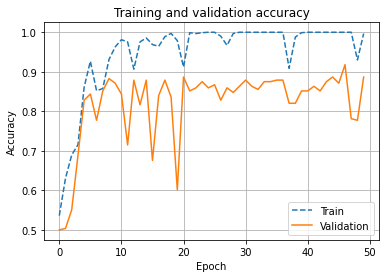

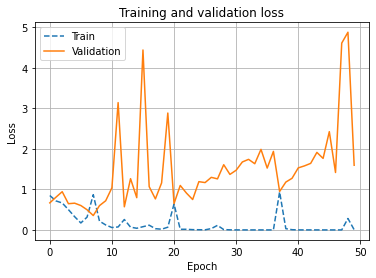

In [19]:
# Retrieve Values of accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc)) # Get number of epochs

# Plot accuracy and loss
plt.figure(edgecolor='w', facecolor='white')
plt.grid()
plt.plot(epochs,acc, linestyle = 'dashed', label = 'Train' )
plt.plot(epochs, val_acc, label = 'Validation')
plt.title ('Training and validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Plot training and validation
plt.figure(edgecolor='w', facecolor='white')
plt.grid()
plt.plot( epochs,loss, linestyle = 'dashed', label = 'Train')
plt.plot( epochs, val_loss, label = 'Validation')
plt.title('Training and validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()